In [1]:
from tqdm import tqdm
from typing import List, Dict
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from flowprintOptimal.sekigo.core.flowRepresentation import FlowRepresentation,PacketFlowRepressentation
from flowprintOptimal.sekigo.dataAnalysis.vNATDataFrameProcessor import VNATDataFrameProcessor
from flowprintOptimal.sekigo.core.flowConfig import FlowConfig
import random
from flowprintOptimal.sekigo.flowUtils.flowDatasets import PacketFlowDataset
from torch.utils.data import Dataset,DataLoader
from torchsampler import ImbalancedDatasetSampler
from sklearn.model_selection import train_test_split
from flowprintOptimal.sekigo.flowUtils.commons import normalizePacketRep
import os
from joblib import Parallel, delayed
from flowprintOptimal.sekigo.flowUtils.commons import saveFlows,loadFlows
from flowprintOptimal.sekigo.dataAnalysis.dataFrameProcessor import UTMobileNetProcessor
from flowprintOptimal.sekigo.flowUtils.dataGetter import getTrainTestOOD
from torch.functional import F
import torch.nn as nn

In [2]:
train_flows,test_flows,ood_flows = getTrainTestOOD(dataset_name= "VNAT", packet_limit= 20, test_size= .2, ood_classes= ["chat"])

full class distrubation
FT           16420
control      13591
streaming     1759
chat          1244
Name: count, dtype: int64
post num packet filter class distrubation
streaming    1265
control       602
chat          492
FT            469
Name: count, dtype: int64
test class distrubation
streaming    245
control      127
FT            96
Name: count, dtype: int64


In [28]:
train_dataset = PacketFlowDataset(flows= train_flows,label_to_index= None,do_aug= True)
test_dataset = PacketFlowDataset(flows= test_flows,label_to_index= train_dataset.label_to_index)
ood_dataset = PacketFlowDataset(flows= ood_flows, label_to_index= None)

In [29]:
train_dataset[0]

{'data': array([[0.04      , 0.        , 1.        ],
        [0.04      , 0.3473466 , 0.        ],
        [0.03466667, 0.4152932 , 1.        ],
        [0.19466667, 0.39307168, 1.        ],
        [0.03466667, 0.34350683, 0.        ],
        [0.06066667, 0.62350187, 0.        ],
        [0.03466667, 0.4216397 , 1.        ],
        [0.42733333, 0.54072109, 1.        ],
        [0.176     , 0.71252412, 0.        ],
        [0.07733333, 0.55736549, 1.        ],
        [0.092     , 0.45822013, 1.        ],
        [0.03466667, 0.36448998, 0.        ],
        [0.38133333, 0.3634976 , 1.        ],
        [0.91866667, 0.39373476, 1.        ],
        [0.754     , 0.24807879, 1.        ],
        [0.01205621, 0.33516189, 0.        ],
        [0.04463436, 0.67703094, 0.        ],
        [0.05533333, 0.68334745, 1.        ],
        [0.05533333, 0.3473466 , 0.        ],
        [0.91866667, 0.75948708, 0.        ]]),
 'label': 0}

In [30]:
from flowprintOptimal.sekigo.modeling.trainers import NNClassificationTrainer
from flowprintOptimal.sekigo.modeling.neuralNetworks import LSTMNetwork,TransformerGenerator,CNNNetwork1D
from flowprintOptimal.sekigo.modeling.loggers import Logger
import torch
#device = torch.device("cpu")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [41]:
class ConfClassificationTrainer(NNClassificationTrainer):
    def __init__(self, classifier, device, logger: Logger):
        super().__init__(classifier, device, logger)
        self.nll_loss = nn.NLLLoss(reduction = "none")
        self.bce_loss = nn.BCELoss(reduction = "none")
        metric_steps = 100
        self.logger.setMetricReportSteps(metric_name= "train_loss", step_size= metric_steps)
        self.logger.setMetricReportSteps(metric_name= "conf_loss", step_size= metric_steps)
        self.logger.setMetricReportSteps(metric_name= "conf_value", step_size= metric_steps)
        self.logger.setMetricReportSteps(metric_name= "conf_loss_weight", step_size= metric_steps)
        self.conf_loss_weight = 0
        self.budget = .5


    def preProcess(self,X,eps = .3):
        X.requires_grad = True
        _,conf_scores = self.classifier(X)
        conf_scores = F.sigmoid(conf_scores)
        loss = -torch.log(conf_scores + 1e-8).mean()
        loss.backward()
        grad = X.grad/torch.linalg.norm(X.grad)
        X = X - grad*eps
        X.required_grad = False
        return X


    
    def trainStep(self, batch, classifier_optimizer):
        X,y = batch["data"].float().to(self.device), batch["label"].to(self.device)
        X = self.preProcess(X)
        model_out,conf_scores = self.classifier(X)
        # doing sigmoid on conf scores
        model_out = F.softmax(model_out,dim= -1)
        conf_scores = F.sigmoid(conf_scores)
        conf_scores = torch.clamp(conf_scores,min= 1e-8, max= 1)
        true_one_hots = F.one_hot(y,model_out.shape[-1])


        classifier_optimizer.zero_grad()
        conf_adjusted_model_out = conf_scores*model_out + (1- conf_scores)*true_one_hots

        conf_loss = self.bce_loss(conf_scores,torch.ones_like(conf_scores)).mean()
        classification_loss = self.nll_loss(torch.log(conf_adjusted_model_out + 1e-8),y).mean()

        loss = classification_loss + conf_loss*self.conf_loss_weight
        loss.backward()
        classifier_optimizer.step()

        self.logger.addMetric(metric_name= "train_loss", value= loss.cpu().item())
        self.logger.addMetric(metric_name= "conf_loss", value= conf_loss.cpu().item())
        self.logger.addMetric(metric_name= "conf_value", value= conf_scores.mean().cpu().item())
        self.logger.addMetric(metric_name= "conf_loss_weight", value= self.conf_loss_weight)

        if conf_loss.item() >= self.budget:
            # if conf loss is more then conf is low so we increase the weight
            self.conf_loss_weight += .1
        else:
            self.conf_loss_weight -= .1
        self.conf_loss_weight = np.clip(self.conf_loss_weight,a_min= 0 , a_max= 1)



        

In [42]:
classifier = CNNNetwork1D(in_channels= 3,num_filters= 32,num_layers= 3,output_dims= [len(train_dataset.label_to_index), 1])
logger= Logger(name= "classification",verbose= True)
logger.default_step_size = 500
classification_trainer = ConfClassificationTrainer(classifier = classifier,device= device,logger= logger)
classification_trainer.train(train_dataset= train_dataset,test_dataset= test_dataset,epochs=200,batch_size= 64,lr= .0001,use_balanced_sampler= True)

classification ---- 1 metric test_f1 = 0.22907900888265545
classification ---- 1 metric test_accuracy = 0.5235042735042735
classification ---- 1 metric train_accuracy = 0.5460385438972163
classification ---- 1 metric train_f1 = 0.23545706371191136
classification ---- 100 metric train_loss = 0.9582885217666626
classification ---- 100 metric conf_loss = 0.6236006212234497
classification ---- 100 metric conf_value = 0.5390512037277222
classification ---- 100 metric conf_loss_weight = 0.795
classification ---- 200 metric train_loss = 0.7530354642868042
classification ---- 200 metric conf_loss = 0.5097833621501923
classification ---- 200 metric conf_value = 0.6022334349155426
classification ---- 200 metric conf_loss_weight = 0.61
classification ---- 300 metric train_loss = 0.5123249210417271
classification ---- 300 metric conf_loss = 0.475104578435421
classification ---- 300 metric conf_value = 0.6247583073377609
classification ---- 300 metric conf_loss_weight = 0.435
classification ---- 40

In [43]:

def getConfScores(dataset,model):
    model.eval()
    confs = []
    is_corrects = []
    max_probs = []
    loader = DataLoader(dataset,batch_size= 64)
    with torch.no_grad():

        for batch in loader:
            data,label = batch["data"].float().to(device),batch["label"].to(device)
            model_out,batch_confs = model(data)

            model_out = F.softmax(model_out, dim= -1)
            batch_max_probs,batch_preds = torch.max(model_out,dim= -1)
            max_probs.extend(batch_max_probs.cpu().numpy().tolist())
            batch_is_corrects = label == batch_preds
            is_corrects.extend(batch_is_corrects.cpu().numpy().tolist())
            batch_confs = F.sigmoid(batch_confs[:,0]).cpu().numpy().tolist()
            confs.extend(batch_confs)
    
    return np.array(confs),np.array(max_probs)

        


In [44]:
confs,max_probs = getConfScores(dataset= train_dataset,model= classifier)
ood_confs,ood_max_probs = getConfScores(dataset= ood_dataset,model= classifier)

(array([200.,  20.,  31.,  17.,  23.,  31.,  37.,   4.,  18., 111.]),
 array([0.48343241, 0.53508627, 0.58674014, 0.638394  , 0.69004786,
        0.74170172, 0.79335558, 0.84500945, 0.89666331, 0.94831717,
        0.99997103]),
 <BarContainer object of 10 artists>)

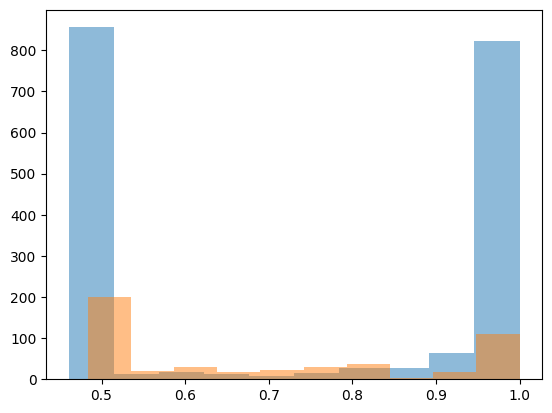

In [45]:
plt.hist(confs,alpha = .5)
plt.hist(ood_confs,alpha = .5)